In [1]:
%%html
<marquee style='width: 50%; color: red;'><b>Всем привет!!!!! Рад вас тут видеть Оцените ноут</b></marquee>

In [2]:
# Author: Timur Abdualimov, SOVIET team
# Competition: Recommended system, SkillFctory
# First date code: 17.05.2020
# Used: Kaggle notebook, GPU!


import numpy as np
import pandas as pd 
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score, f1_score, precision_score, recall_score

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input, BatchNormalization
from keras.optimizers import Adam
from keras import metrics
from keras.utils.vis_utils import plot_model

import scikitplot as skplt

import sys
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
RANDOM_SEED = 13

print('Python       :', sys.version.split('\n')[0])
print('Pandas       :', pd.__version__)
print('Numpy        :', np.__version__)
print('Keras        :', keras.__version__)

Python       : 3.8.5 | packaged by conda-forge | (default, Jul 31 2020, 02:39:48) 
Pandas       : 1.1.0
Numpy        : 1.18.5
Keras        : 2.4.3


In [3]:
def open_data():
    """ open datasets"""
    global train, test, sample_submission # объявляем переменные глобальными
    train = pd.read_csv('data/train.csv.zip', low_memory=False)
    train = train.drop_duplicates().reset_index(drop = True) # удалим дубликаты, если есть
    test = pd.read_csv('data/test.csv.zip', low_memory=False)
    sample_submission = pd.read_csv('data/sample_submission.csv.zip', low_memory=False)
    
open_data() # открываем все и записываем датасет в переменные

def param_data(data): # посмотрим на данные
    """dataset required parameters """
    param = pd.DataFrame({
              'dtypes': data.dtypes.values,
              'nunique': data.nunique().values,
              'isna': data.isna().sum().values,
              'loc[0]': data.loc[0].values,
              }, 
             index = data.loc[0].index)
    return param

pd.concat([param_data(train), param_data(test)], 
          axis=1, 
          keys = [f'↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓ {train.shape}', f'↓ ТЕСТОВАЯ ВЫБОРКА ↓ {test.shape}'],  
          sort=False)

↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓ (826895, 14)                      \
                                           dtypes   nunique      isna   
overall                                   float64       5.0       0.0   
verified                                     bool       2.0       0.0   
reviewTime                                 object    4580.0       0.0   
asin                                       object   41302.0       0.0   
reviewerName                               object  101207.0     164.0   
reviewText                                 object  686739.0     274.0   
summary                                    object  411451.0     166.0   
unixReviewTime                              int64    4580.0       0.0   
vote                                       object     311.0  712944.0   
style                                      object   25892.0  398698.0   
image                                      object    6636.0  819916.0   
userid                                      int64  127448.0       0.0   
itemid                                      int64   41302.0       0.0   
rating                                    float64       2.0       0.0   
Id                                            NaN       NaN       NaN   

                                                                   \
                                                           loc[0]   
overall                                                         5   
verified                                                     True   
reviewTime                                             10 4, 2016   
asin                                                   B01CPNIEQG   
reviewerName                                              Heather   
reviewText      These are my FAVORITE spices in my collection....   
summary                           Must Add to your Spice kitchen!   
unixReviewTime                                         1475539200   
vote                                                          NaN   
style                                                         NaN   
image                                                         NaN   
userid                                                     102179   
itemid                                                      37138   
rating                                                          1   
Id                                                            NaN   

               ↓ ТЕСТОВАЯ ВЫБОРКА ↓ (285965, 11)                      \
                                          dtypes   nunique      isna   
overall                                      NaN       NaN       NaN   
verified                                    bool       2.0       0.0   
reviewTime                                object    4349.0       0.0   
asin                                      object   37876.0       0.0   
reviewerName                              object   86815.0      47.0   
reviewText                                   NaN       NaN       NaN   
summary                                      NaN       NaN       NaN   
unixReviewTime                             int64    4349.0       0.0   
vote                                      object     198.0  246503.0   
style                                     object   18904.0  138285.0   
image                                     object    2306.0  283597.0   
userid                                     int64  109357.0       0.0   
itemid                                     int64   37876.0       0.0   
rating                                       NaN       NaN       NaN   
Id                                         int64  285965.0       0.0   

                            
                    loc[0]  
overall                NaN  
verified              True  
reviewTime      10 1, 2016  
asin            B001E5E3X0  
reviewerName     Rudys Mom  
reviewText             NaN  
summary                NaN  
unixReviewTime  1475280000  
vote                   NaN  
style                  NaN  
image                  NaN

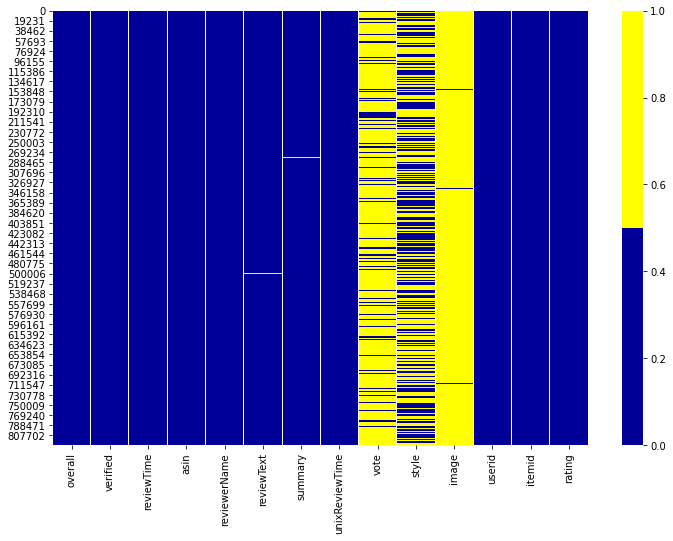

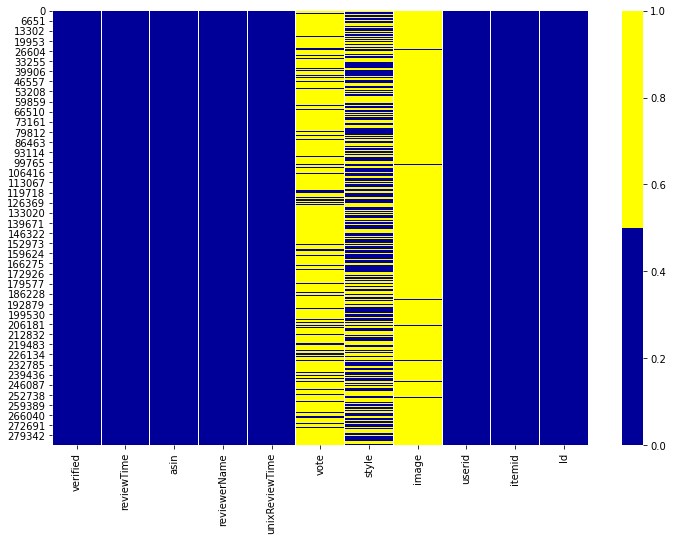

In [4]:
def viz_na(data):
    """NA visualisation"""
    global cols
    cols = data.columns # запишем названия строки сделаем переменную глобальной
    # определяем цвета 
    # желтый - пропущенные данные, синий - не пропущенные
    colours = ['#000099', '#ffff00'] 
    sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours))
    plt.show()


viz_na(train)
viz_na(test)

In [5]:
def stat_na_per_percent(data):
    print(f'{data.shape}')
    for col in data.columns:
        pct_missing = np.mean(data[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))
    print("END", end = '\n\n')
stat_na_per_percent(train)
stat_na_per_percent(test)

(826895, 14)
overall - 0.0%
verified - 0.0%
reviewTime - 0.0%
asin - 0.0%
reviewerName - 0.0%
reviewText - 0.0%
summary - 0.0%
unixReviewTime - 0.0%
vote - 86.0%
style - 48.0%
image - 99.0%
userid - 0.0%
itemid - 0.0%
rating - 0.0%
END

(285965, 11)
verified - 0.0%
reviewTime - 0.0%
asin - 0.0%
reviewerName - 0.0%
unixReviewTime - 0.0%
vote - 86.0%
style - 48.0%
image - 99.0%
userid - 0.0%
itemid - 0.0%
Id - 0.0%
END



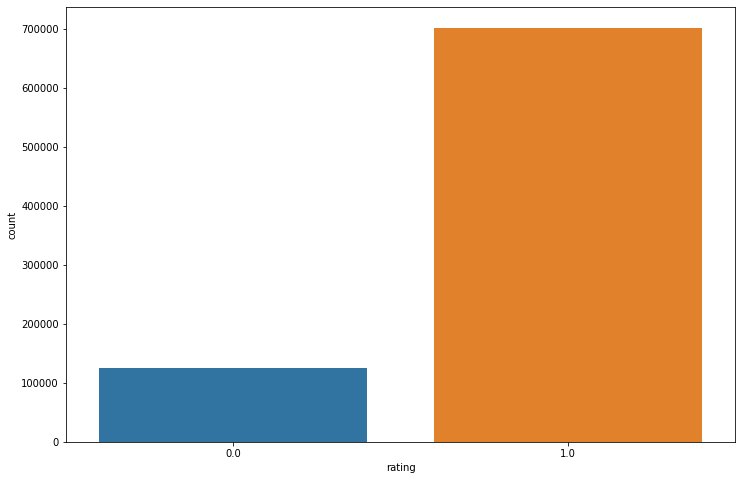

In [6]:
sns.countplot(train['rating']);

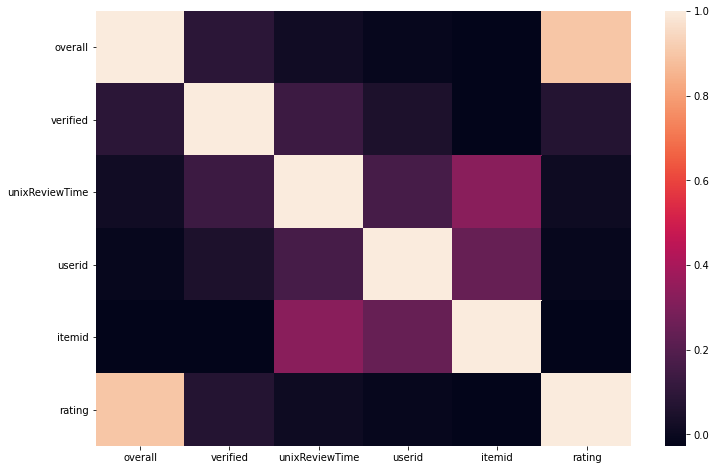

In [7]:
sns.heatmap(train.corr())
plt.show()

In [8]:
train_data_GB = pd.DataFrame({
    'userid': train['userid'],
    'itemid': train['itemid'],
    'rating': train['rating']
})

test_data_GB = pd.DataFrame({
    'userid': test['userid'],
    'itemid': test['itemid'],
})

train_data_GB = pd.get_dummies(train_data_GB, prefix='', prefix_sep='', columns=['rating'])

In [9]:
#train_data_GB['rating'] = train_data_GB['rating'].astype(int)
## unisue users, books
userid, utemid = len(train_data_GB.userid.unique()), len(train_data_GB.itemid.unique())


f'The dataset includes {len(train_data_GB)} ratings by {userid} unique users on {utemid} unique itemid.'

'The dataset includes 826895 ratings by 127448 unique users on 41302 unique itemid.'

In [10]:
train_, test_ = train_test_split(train_data_GB, test_size=0.01)
f"The training and testing data include {len(train), len(test)} records."

'The training and testing data include (826895, 285965) records.'

### Tabular data method

In [11]:
keras.backend.clear_session()
## define the number of latent factors (can be different for the users and books)
dim_embedding_user = 40
dim_embedding_book = 40

## book embedding
utem_input= Input(shape=[1], name='Utem')
utem_embedding = Embedding(utemid + 1, dim_embedding_book, name='Utem-Embedding')(utem_input)
utem_vec = Flatten(name='Utem-Flatten')(utem_embedding)
utem_vec = Dropout(0.5)(utem_vec)

## user embedding
user_input = Input(shape=[1], name='User')
user_embedding = Embedding(userid + 1, dim_embedding_user, name ='User-Embedding')(user_input)
user_vec = Flatten(name ='User-Flatten')(user_embedding)
user_vec = Dropout(0.5)(user_vec)

## concatenate flattened values 
concat = concatenate([utem_vec, user_vec])
concat_dropout = Dropout(0.5)(concat)

## add dense layer (can try more)
dense_1 = Dense(30, name ='Fully-Connected1', activation='relu')(concat)
dense_1 = Dense(30, name ='Fully-Connected2', activation='relu')(dense_1)
dense_1 = Dense(30, name ='Fully-Connected3', activation='relu')(dense_1)
dense_1 = Dense(30, name ='Fully-Connected4', activation='relu')(dense_1)
## define output (can try sigmoid instead of relu)
result = Dense(2, activation ='softmax',name ='Activation')(dense_1)

## define model with 2 inputs and 1 output
model_tabular = Model([user_input, utem_input], result)
model_tabular.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Utem (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Utem-Embedding (Embedding)      (None, 1, 40)        1652120     Utem[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 40)        5097960     User[0][0]                       
_______________________________________________________________________________________

In [12]:
import pydot
# https://github.com/XifengGuo/CapsNet-Keras/issues/69
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

In [13]:
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)

<module 'keras.utils.vis_utils' from '/opt/conda/lib/python3.8/site-packages/keras/utils/vis_utils.py'>

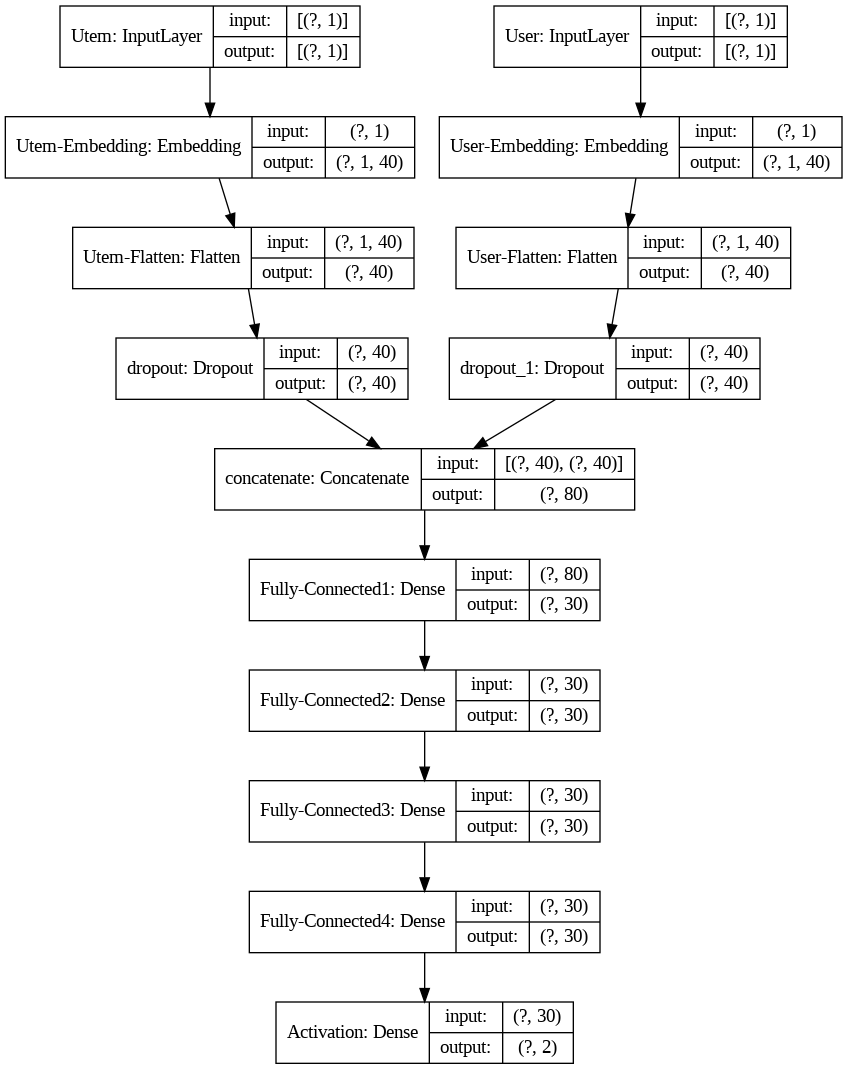

In [14]:
plot_model(model_tabular, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
## specify learning rate (or use the default by specifying optimizer = 'adam')
opt_adam = Adam(lr = 0.0003)

In [16]:
## compile model
model_tabular.compile(optimizer= opt_adam, loss= ['binary_crossentropy'], metrics=[keras.metrics.AUC()])

In [17]:
## fit model
history_tabular = model_tabular.fit([train_['userid'], train_['itemid']],
                                    train_.iloc[:,[-2,-1]],
                                    batch_size = 1000,
                                    validation_split = 0.1,
                                    epochs = 4,
                                    verbose = 1)

Epoch 1/4
  1/737 [..............................] - ETA: 0s - loss: 0.6900 - auc: 0.7107

InvalidArgumentError:  indices[703,0] = 41315 is not in [0, 41303)
	 [[node functional_1/Utem-Embedding/embedding_lookup (defined at <ipython-input-17-aa7cfa7f45df>:2) ]] [Op:__inference_train_function_1682]

Errors may have originated from an input operation.
Input Source operations connected to node functional_1/Utem-Embedding/embedding_lookup:
 functional_1/Utem-Embedding/embedding_lookup/1142 (defined at /opt/conda/lib/python3.8/contextlib.py:113)

Function call stack:
train_function


In [ ]:
test_pred_GB = model_tabular.predict([test_data_GB['userid'], test_data_GB['itemid']])[:,1]

In [ ]:
test_pred = model_tabular.predict([test_['userid'], test_['itemid']])

In [ ]:
skplt.metrics.plot_roc(test_.iloc[:, -1], test_pred)
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(test_.iloc[:, -1], test_pred[:,1])
auc = roc_auc_score(test_.iloc[:,  -1], test_pred[:, 1])
accuracy = accuracy_score(test_.iloc[:, -1], np.argmax(test_pred, axis = -1))
f1 = f1_score(test_.iloc[:, -1], np.argmax(test_pred, axis = -1))
precision =  precision_score(test_.iloc[:, -1], np.argmax(test_pred, axis = -1))
recall = recall_score(test_.iloc[:, -1], np.argmax(test_pred, axis = -1))

print('FP, TP              :', sum(fpr), sum(tpr))
print('ROC_AUC_SCORE       :', auc)
print('accuracy            :', accuracy)
print('precision           :', precision)
print('recall              :', recall)
print('f1                  :', f1)

In [ ]:
sample_submission['rating'] = test_pred_GB
sample_submission.to_csv('submission_XXXXXX.csv', index=False)
sample_submission.head(3)

In [ ]:
#Эмбединги
utem_embedding_weights = model_tabular.layers[2].get_weights()[0]